In [10]:
# Data loading and manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text preprocessing
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine learning algorithms & evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Optional (Advanced): Pretrained BERT embeddings
# Make sure to install transformers using: pip install transformers
from transformers import BertTokenizer, BertModel

# NLTK downloads (only need to run once)
nltk.download('punkt')
nltk.download('stopwords')

# SpaCy model (only need to run once)
# python -m spacy download en_core_web_sm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Data Exploration and Cleaning**

# 1.Load the dataset using pandas and inspect its structure.

In [11]:
df_train = pd.read_csv("/content/drive/MyDrive/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test (1).csv")
df_sample_sub = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")

In [12]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
df_train.shape

(7613, 5)

In [14]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [15]:
df_test.shape

(3263, 4)

In [16]:
df_sample_sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [17]:
df_sample_sub.shape

(3263, 2)

# 2. Check for null values and handle missing data appropriately.

In [18]:
df_train.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [19]:
# Drop rows where 'keyword' is null
df_train = df_train.dropna(subset=['keyword'])

df_train = df_train.reset_index(drop=True)


In [20]:
df_train.isnull().sum()

,0
id,0
keyword,0
location,2472
text,0
target,0


In [21]:
df_train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [22]:
df_train['location'] = df_train['location'].fillna('No Location')


In [23]:
df_train.isnull().sum()

,0
id,0
keyword,0
location,0
text,0
target,0


# 3. exploratory data analysis (EDA)

In [24]:
# Count of each class in the target column
print(df_train['target'].value_counts())


target
0    4323
1    3229
Name: count, dtype: int64


/tmp/ipython-input-25-2742267650.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df_train, palette='pastel')


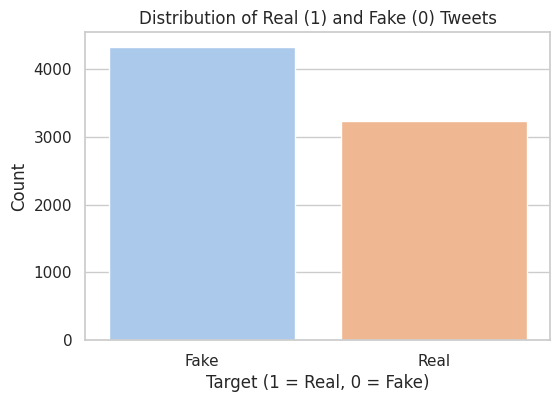

In [25]:
# Set style
sns.set(style='whitegrid')

# Plotting the target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=df_train, palette='pastel')

# Adding labels
plt.title('Distribution of Real (1) and Fake (0) Tweets')
plt.xlabel('Target (1 = Real, 0 = Fake)')
plt.ylabel('Count')
plt.xticks([1, 0], ['Real', 'Fake'])

plt.show()

In [26]:
# Add a new column 'text_length' which stores the length of each news article
df_train['text_length'] = df_train['text'].apply(len)

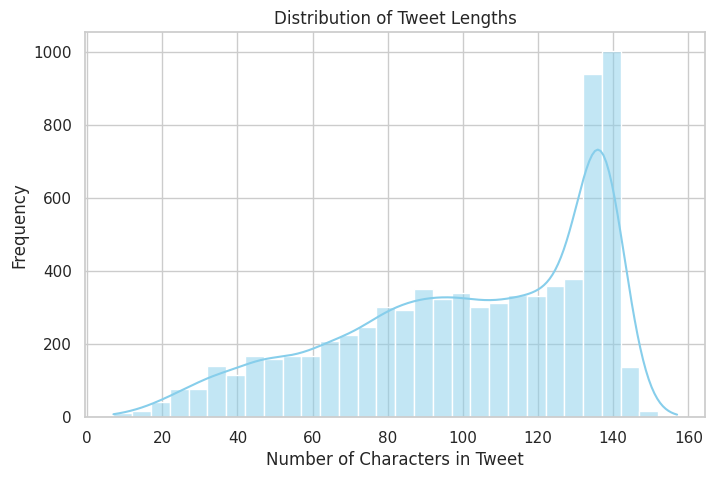

In [27]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_train, x='text_length', bins=30, kde=True, color='skyblue')

plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of Characters in Tweet')
plt.ylabel('Frequency')
plt.show()


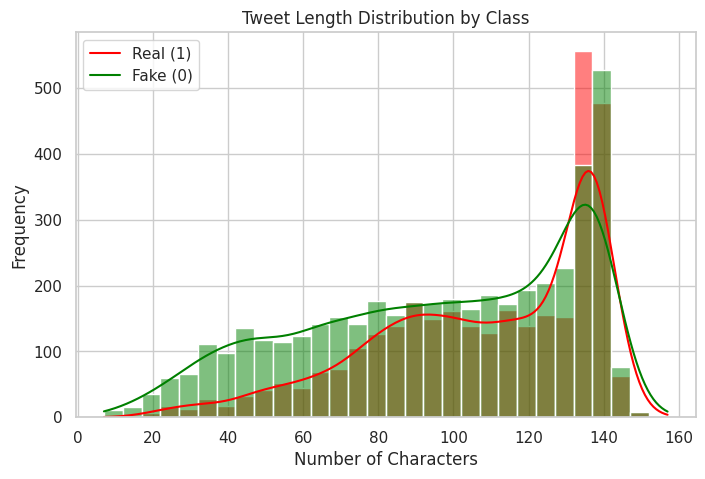

In [28]:
plt.figure(figsize=(8,5))
sns.histplot(data=df_train, x='text_length', hue='target', bins=30, kde=True, palette=['green', 'red'])

plt.title('Tweet Length Distribution by Class')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend(labels=['Real (1)', 'Fake (0)'])
plt.show()


/tmp/ipython-input-29-3592424420.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')


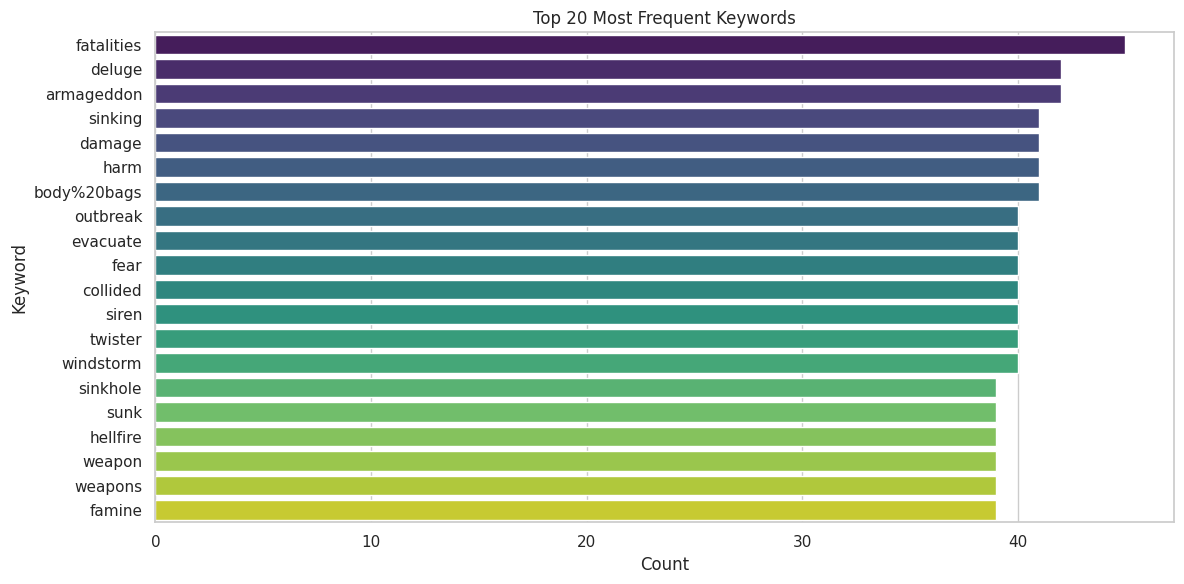

In [29]:
# Plot top 20 most frequent keywords
plt.figure(figsize=(12, 6))
top_keywords = df_train['keyword'].value_counts().head(20)

sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')
plt.title("Top 20 Most Frequent Keywords")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

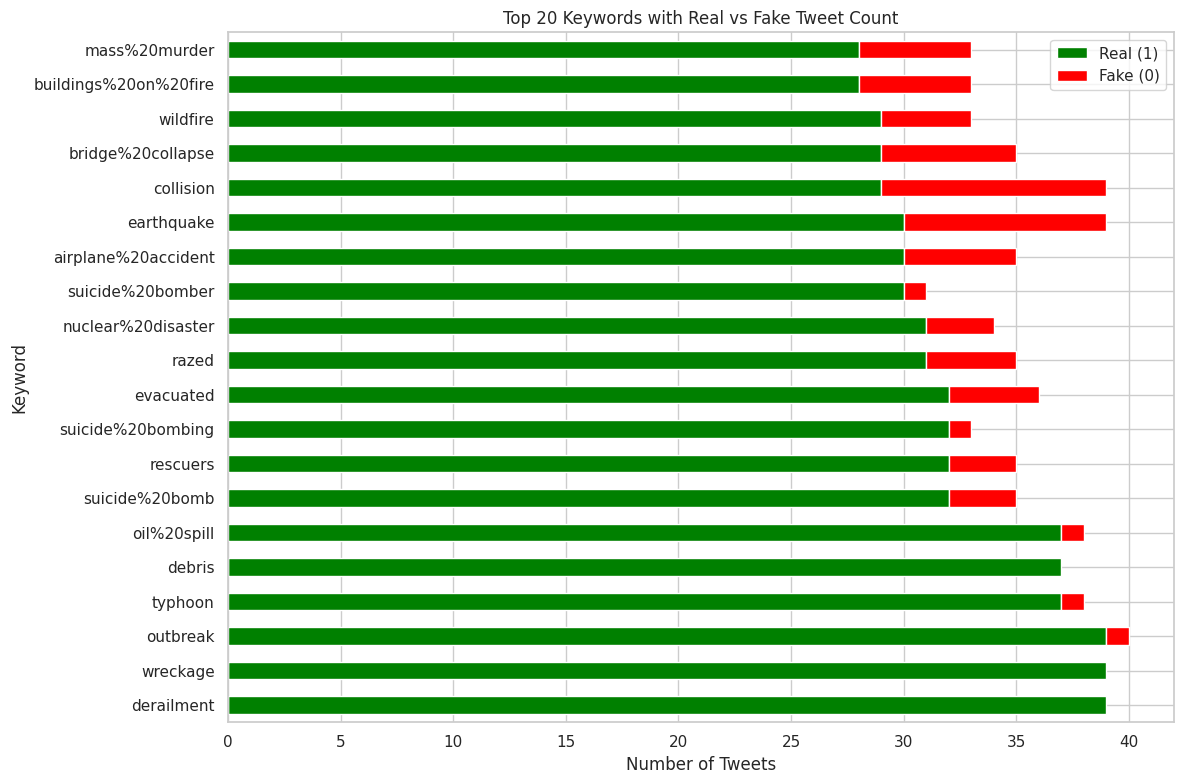

In [30]:
# Count of fake vs real tweets for each keyword
plt.figure(figsize=(14, 8))
keyword_target = df_train.groupby(['keyword', 'target']).size().unstack().fillna(0)
keyword_target = keyword_target.sort_values(by=1, ascending=False).head(20)  # top 20 keywords with most fake tweets

keyword_target[[1, 0]].plot(kind='barh', stacked=True, figsize=(12, 8), color=['green', 'red'])

plt.title("Top 20 Keywords with Real vs Fake Tweet Count")
plt.xlabel("Number of Tweets")
plt.ylabel("Keyword")
plt.legend(["Real (1)", "Fake (0)"])
plt.tight_layout()
plt.show()

In [31]:
# Filter tweets
fake_tweets = df_train[df_train['target'] == 0]['text']
real_tweets = df_train[df_train['target'] == 1]['text']


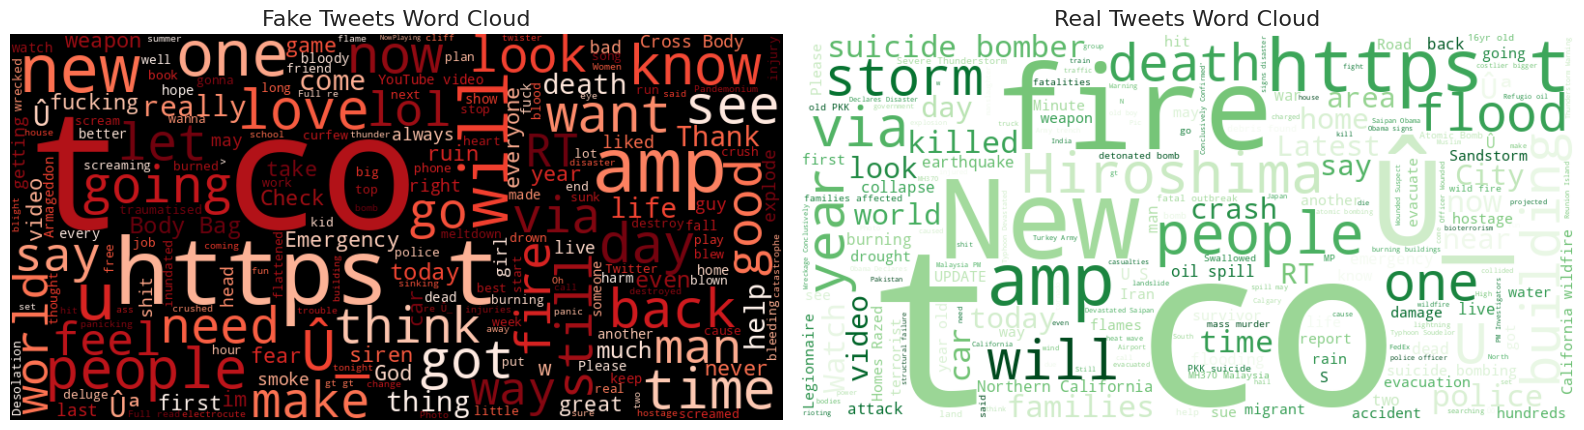

In [32]:
# Join all text together
fake_text = " ".join(fake_tweets)
real_text = " ".join(real_tweets)

# Generate word clouds
fake_wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(fake_text)
real_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(real_text)

# Plot side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Fake Tweets Word Cloud", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Real Tweets Word Cloud", fontsize=16)

plt.tight_layout()
plt.show()


# **Text Preprocessing**

# 1. Remove punctuation, special characters, and numbers from tweets using regex.


In [33]:
def clean_tweet(text):

    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Remove usernames (e.g., @user)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (but keep the word)
    text = re.sub(r'#', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [34]:
df_train['clean_text'] = df_train['text'].apply(clean_tweet)


In [35]:
df_train

,id,keyword,location,text,target,text_length,clean_text
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,Wholesale Markets ablaze
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67,We always try to bring the heavy metal RT
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,AFRICANBAZE Breaking newsNigeria flag set abla...
3,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34,Crying out for more Set me ablaze
4,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
...,...,...,...,...,...,...,...
7547,10830,wrecked,No Location,@jt_ruff23 @cameronhacker and I wrecked you both,0,48,and I wrecked you both
7548,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,107,Three days off from work and theyve pretty muc...
7549,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,93,FX forex trading Cramer Igers words that wreck...
7550,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,104,Great atmosphere at the British Lion gig tonig...


# 2. Convert text to lowercase and remove stopwords using nltk.

In [36]:
df_train['clean_text'] = df_train['clean_text'].str.lower()

In [37]:
df_train

,id,keyword,location,text,target,text_length,clean_text
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,wholesale markets ablaze
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67,we always try to bring the heavy metal rt
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,africanbaze breaking newsnigeria flag set abla...
3,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34,crying out for more set me ablaze
4,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,on plus side look at the sky last night it was...
...,...,...,...,...,...,...,...
7547,10830,wrecked,No Location,@jt_ruff23 @cameronhacker and I wrecked you both,0,48,and i wrecked you both
7548,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,107,three days off from work and theyve pretty muc...
7549,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,93,fx forex trading cramer igers words that wreck...
7550,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,104,great atmosphere at the british lion gig tonig...


In [38]:
# Download stopwords list (only once)
nltk.download('stopwords')

# Load English stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
def remove_stopwords(text):
    # Tokenize the text (split into words)
    words = text.split()

    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Join back to text
    return " ".join(filtered_words)


In [40]:
df_train['clean_text'] = df_train['clean_text'].apply(remove_stopwords)


In [41]:
df_train

,id,keyword,location,text,target,text_length,clean_text
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,wholesale markets ablaze
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67,always try bring heavy metal rt
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,africanbaze breaking newsnigeria flag set abla...
3,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34,crying set ablaze
4,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,plus side look sky last night ablaze
...,...,...,...,...,...,...,...
7547,10830,wrecked,No Location,@jt_ruff23 @cameronhacker and I wrecked you both,0,48,wrecked
7548,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,107,three days work theyve pretty much wrecked hah...
7549,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,93,fx forex trading cramer igers words wrecked di...
7550,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,104,great atmosphere british lion gig tonight hear...


# 3. Apply stemming and lemmatization to normalize text using nltk and spacy

In [42]:
# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize text
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])  # Get base form (lemma) of each word

# Apply on clean_text column and update it
df_train['clean_text'] = df_train['clean_text'].apply(lemmatize_text)


In [43]:
# Initialize stemmer
stemmer = PorterStemmer()

# Function to apply stemming
def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split()])  # Trim word to its stem/root

# Apply on clean_text column and update it
df_train['clean_text'] = df_train['clean_text'].apply(stem_text)

In [44]:
df_train

,id,keyword,location,text,target,text_length,clean_text
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,wholesal market ablaz
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67,alway tri bring heavi metal rt
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,africanbaz break newsnigeria flag set ablaz aba
3,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34,cri set ablaz
4,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,plu side look sky last night ablaz
...,...,...,...,...,...,...,...
7547,10830,wrecked,No Location,@jt_ruff23 @cameronhacker and I wrecked you both,0,48,wreck
7548,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,107,three day work they ve pretti much wreck hahah...
7549,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,93,fx forex trade cramer iger word wreck disney s...
7550,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,104,great atmospher british lion gig tonight hear ...


In [45]:
# Show original vs cleaned text side by side
df_train[['text', 'clean_text']].sample(10)


,text,clean_text
2079,https://t.co/oIfN28HpCS @ArianaGrande @ScreamQ...,katherin death
7312,PHOTOS: The Rocky Fire has grown into Californ...,photo rocki fire grow california destruct wild...
4384,#hot Funtenna: hijacking computers to send da...,hot funtenna hijack comput send datum sound wa...
2064,Xbox 360 Pro Console - *Red Ring of Death* - F...,xbox pro consol red ring death full read ebay
6309,We offer #preventative services such as cablin...,offer prevent servic cabl brace stop structur ...
4381,#hot Funtenna: hijacking computers to send da...,hot funtenna hijack comput send datum sound wa...
1502,???? #Krefeld: the incident happened in a chem...,krefeld incid happen chemic industri park emer...
1663,Even then our words slip and souls coincide Fi...,even word slip soul coincid fine subatom spell...
4697,https://t.co/4i0rKcbK1D\nSON OF SAVIOR LAVA VIDEO,son savior lava video
1070,The majority of those killed were civilians on...,major kill civilian ground jet first bomb citi...


# 4. Visualize the most frequently used words with wordcloud and matplotlib.


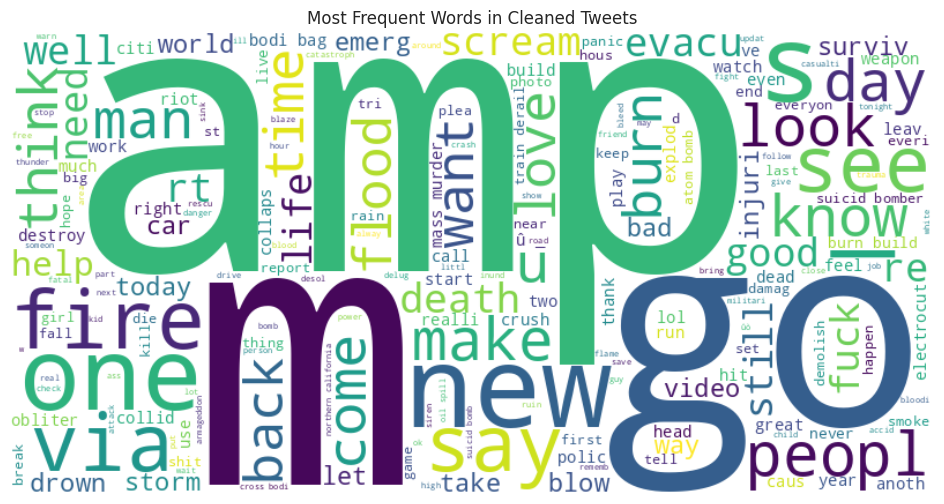

In [46]:
# Join all cleaned text into one large string
all_text = " ".join(df_train['clean_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Cleaned Tweets")
plt.show()


In [47]:
# Filter tweets
fake_tweets = df_train[df_train['target'] == 0]['clean_text']
real_tweets = df_train[df_train['target'] == 1]['clean_text']


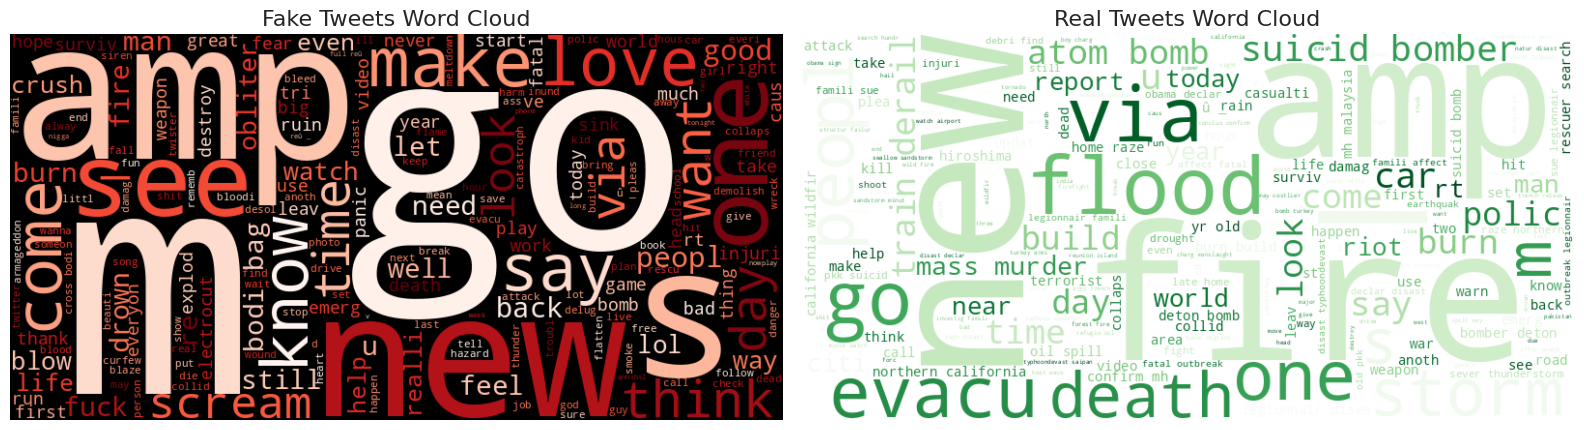

In [48]:
# Join all text together
fake_text = " ".join(fake_tweets)
real_text = " ".join(real_tweets)

# Generate word clouds
fake_wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(fake_text)
real_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(real_text)

# Plot side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Fake Tweets Word Cloud", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Real Tweets Word Cloud", fontsize=16)

plt.tight_layout()
plt.show()


# **Feature Extraction**

# 1.Transform the preprocessed text into numerical features using:

In [49]:
# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Transform text data into numerical vectors
X_bow = count_vectorizer.fit_transform(df_train['clean_text'])


In [50]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform text data into TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df_train['clean_text'])


# 2. Explore word embeddings (e.g., Word2Vec or pre-trained BERT embeddings using transformers) for better feature extraction.

In [51]:
!pip install gensim

In [52]:
from gensim.models import Word2Vec
# Prepare tokenized text data
tokenized_text = df_train['clean_text'].apply(lambda x: x.split())

# Train Word2Vec on your tweets
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=2, workers=4)

# Get vector for one word
w2v_model.wv['fire']

array([-3.17561984e-01,  3.73893231e-01,  5.93523979e-01,  6.19111815e-03,
       -1.38824657e-01, -1.04741549e+00, -9.62068737e-02,  1.15725327e+00,
       -7.28959143e-01, -2.60443598e-01, -5.16404271e-01, -1.15078366e+00,
       -4.20813560e-01,  4.26631309e-02,  2.54964978e-01, -1.65327147e-01,
        4.54707831e-01, -7.09880054e-01,  6.25116050e-01, -1.06496334e+00,
        3.03313762e-01,  3.07525337e-01,  1.77918494e-01, -1.59682497e-01,
       -4.88201946e-01,  2.40506560e-01, -6.92308664e-01, -4.11135972e-01,
       -7.90202558e-01,  1.40592083e-01,  7.58474469e-01,  4.01269734e-01,
        4.29280810e-02, -4.20654982e-01, -1.93040416e-01,  1.11371601e+00,
       -8.58879089e-02, -4.33300585e-01, -3.28713566e-01, -1.28045607e+00,
        8.87254924e-02, -7.30536044e-01, -1.16673216e-01,  1.42538240e-02,
        5.58085620e-01, -7.84065068e-01, -6.49622858e-01, -1.54097021e-01,
        1.77959070e-01,  3.70758027e-01,  5.41293383e-01, -5.11870027e-01,
       -4.09580797e-01, -

In [53]:
def get_avg_vector(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

# Apply to each tweet
df_train['w2v_vector'] = tokenized_text.apply(get_avg_vector)

In [54]:
df_train

,id,keyword,location,text,target,text_length,clean_text,w2v_vector
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,wholesal market ablaz,"[-0.07148317, 0.07751834, 0.12686022, 0.004850..."
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67,alway tri bring heavi metal rt,"[-0.12579937, 0.14802901, 0.22900166, 0.008112..."
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,africanbaz break newsnigeria flag set ablaz aba,"[-0.10670151, 0.12508301, 0.20031886, 0.006231..."
3,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34,cri set ablaz,"[-0.102734245, 0.12074471, 0.19040139, 0.00808..."
4,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,plu side look sky last night ablaz,"[-0.11305482, 0.13426064, 0.20747508, 0.008956..."
...,...,...,...,...,...,...,...,...
7547,10830,wrecked,No Location,@jt_ruff23 @cameronhacker and I wrecked you both,0,48,wreck,"[-0.17759503, 0.19354133, 0.3335782, 0.0092323..."
7548,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,107,three day work they ve pretti much wreck hahah...,"[-0.15015352, 0.17668578, 0.27523574, 0.009720..."
7549,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,93,fx forex trade cramer iger word wreck disney s...,"[-0.06616485, 0.077721834, 0.12832993, 0.00305..."
7550,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,104,great atmospher british lion gig tonight hear ...,"[-0.09253101, 0.107960165, 0.1792654, 0.006588..."


# **Model Building**

# 1. Split the data into training and testing sets using train_test_split.

In [55]:
# Features: stacked word vectors (each tweet → 100-dim vector)
X = np.vstack(df_train['w2v_vector'].values)

# Target: 1 = real, 0 = fake
y = df_train['target']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 2. Train different machine learning models, including:

# 1. Logistic Regression

In [65]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.68      0.75       637

    accuracy                           0.81      1511
   macro avg       0.81      0.79      0.79      1511
weighted avg       0.81      0.81      0.80      1511



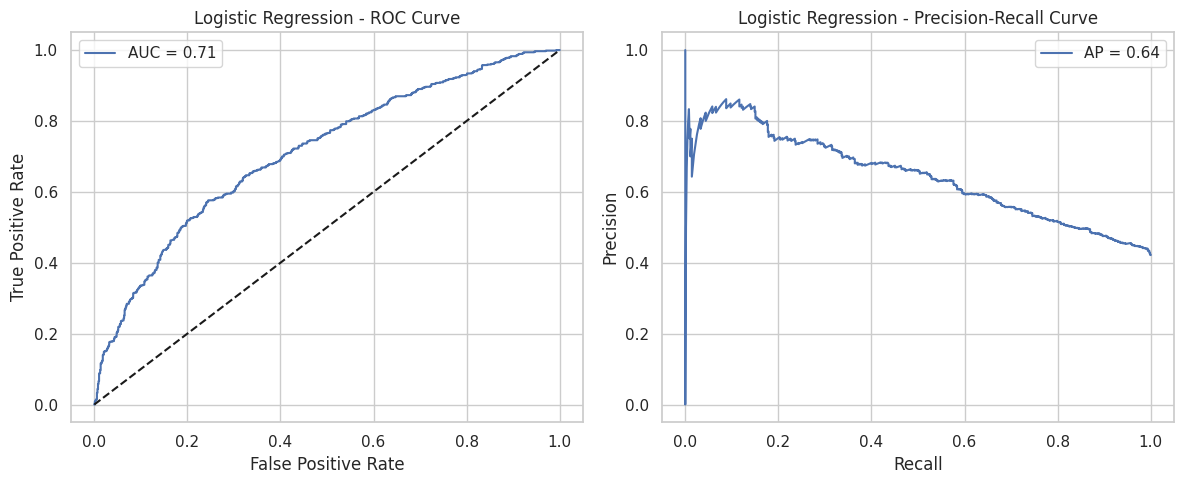

In [57]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Prediction scores
y_scores_lr = lr_model.decision_function(X_test)

# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Precision-Recall
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_scores_lr)
ap_lr = average_precision_score(y_test, y_scores_lr)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f"AUC = {roc_auc_lr:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Logistic Regression - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_lr, precision_lr, label=f"AP = {ap_lr:.2f}")
plt.title("Logistic Regression - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()


# 2. Support Vector Machine (SVM)

In [58]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
print("SVM Report:")
print(classification_report(y_test, y_pred_svm))

SVM Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       874
           1       0.00      0.00      0.00       637

    accuracy                           0.58      1511
   macro avg       0.29      0.50      0.37      1511
weighted avg       0.33      0.58      0.42      1511



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


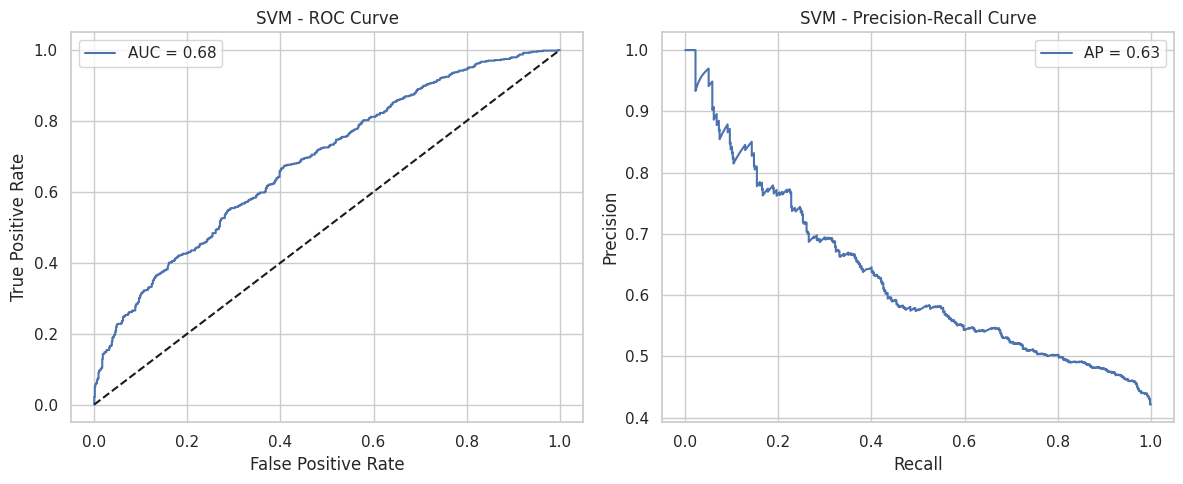

In [59]:
# Prediction scores
y_scores_svm = svm_model.decision_function(X_test)

# ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Precision-Recall
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_scores_svm)
ap_svm = average_precision_score(y_test, y_scores_svm)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_svm, tpr_svm, label=f"AUC = {roc_auc_svm:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("SVM - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_svm, precision_svm, label=f"AP = {ap_svm:.2f}")
plt.title("SVM - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()


# 3. Naive Bayes

In [60]:
# Vectorize text using TF-IDF
from sklearn.naive_bayes import MultinomialNB
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df_train['clean_text'])

# Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df_train['target'], test_size=0.2, random_state=42)

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict & report
y_pred = nb_model.predict(X_test)
print("Naive Bayes (TF-IDF) Report:")
print(classification_report(y_test, y_pred))

Naive Bayes (TF-IDF) Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.68      0.74       637

    accuracy                           0.80      1511
   macro avg       0.81      0.78      0.79      1511
weighted avg       0.80      0.80      0.80      1511



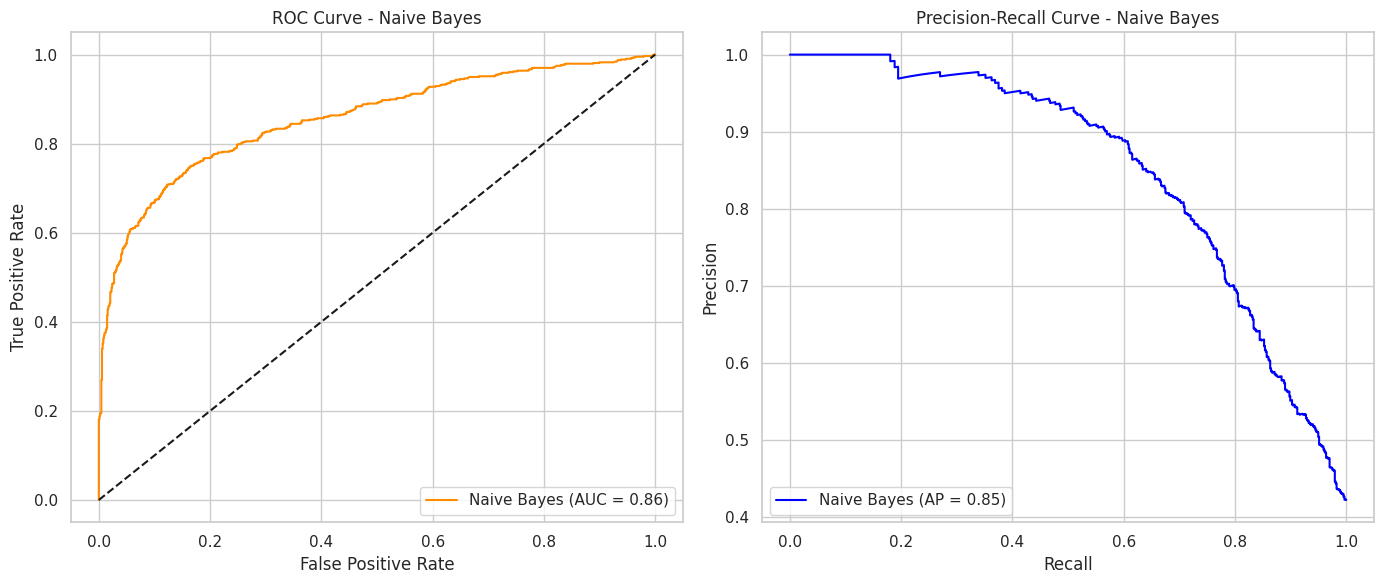

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Get predicted probabilities for the positive class (1)
y_scores_nb = nb_model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(14, 6))

# 🔹 ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_scores_nb)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Naive Bayes (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend(loc="lower right")

# 🔹 Precision-Recall Curve
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_scores_nb)
ap_score = average_precision_score(y_test, y_scores_nb)
plt.plot(recall, precision, label=f"Naive Bayes (AP = {ap_score:.2f})", color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Naive Bayes")
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


# **Hyperparameter Tuning**

# 1. Use GridSearchCV or RandomizedSearchCV from sklearn to optimize hyperparameters for the models.

In [62]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'class_weight': [None, 'balanced']
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Evaluate on test data
print("Best Parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       874
           1       0.78      0.74      0.76       637

    accuracy                           0.80      1511
   macro avg       0.80      0.79      0.80      1511
weighted avg       0.80      0.80      0.80      1511



Key Observations
Naive Bayes performs well out of the box and gives 80% accuracy with good balance between precision and recall.

Untuned Logistic Regression performed poorly on class 1 (F1-score = 0.32).

SVM completely failed to generalize for class 1 (likely due to class imbalance or default parameters).

After GridSearchCV tuning, Logistic Regression performance matched Naive Bayes and improved significantly (from F1 = 0.32 ➝ 0.76 for class 1).

Conclusion
Hyperparameter tuning using GridSearchCV significantly improved Logistic Regression, making it as effective as Naive Bayes.

Naive Bayes + TF-IDF is strong for text classification problems and works well without much tuning.

SVM needs further tuning (try C, kernel, and class_weight using GridSearchCV) before it can be fairly compared.

# **Visualization and Analysis**

# 1. Plot ROC curves and Precision-Recall curves for all models.

In [63]:
# i have made  all curves with the models above

# 2. Display misclassified examples and analyze reasons for failure.

In [66]:
# Predict using Logistic Regression model
y_pred_lr = lr_model.predict(X_test)

# Get misclassified indexes
misclassified_mask = (y_pred_lr != y_test)

# Create a DataFrame of misclassified samples
misclassified_df = df_train.iloc[y_test.index[misclassified_mask]].copy()
misclassified_df["True Label"] = y_test[misclassified_mask].values
misclassified_df["Predicted Label"] = y_pred_lr[misclassified_mask]

# Show top 10 misclassified tweets
print(" Misclassified Tweets (Logistic Regression):")
print(misclassified_df[['text', 'True Label', 'Predicted Label']].head(10))


 Misclassified Tweets (Logistic Regression):
                                                   text  True Label  \
1406  Benzema increasingly looks to be a casualty of...           1   
6537  Patient-reported outcomes in long-term survivo...           1   
6590  @KurtSchlichter  He's already done it by negot...           1   
2462  @binellithresa TY for the follow Go To http://...           1   
4953  @kiranahmedd US military and Nato are fighting...           1   
2447  Thanks a lot roadworks men cos a tube strike w...           1   
1393  @irishspy What you don't think the Allies shou...           1   
3613  I liked a @YouTube video http://t.co/43sXG9Z6x...           1   
6508  It's a miracle that mankind survived 70 years ...           1   
544   USA TODAY: .@FedEx will no longer to transport...           0   

      Predicted Label  
1406                0  
6537                0  
6590                0  
2462                0  
4953                0  
2447                0  
1393 

Analysis of Misclassified Tweets (Logistic Regression)
1. Complex Sentence Structure
Example:
"Two giant cranes holding a bridge collapse into each other in the Netherlands."

This sentence contains disaster-related words, but the structure is complex. Logistic Regression with average Word2Vec embeddings may not capture the full meaning of such sentences.

2. Hashtags but Weak Context
Example:
"#Arsonist arrested for setting many fires."

The presence of a hashtag and serious keywords suggests a fake/disaster tweet, but the model may not effectively handle hashtag tokens or may not have seen enough similar examples during training.

3. Conversational Format
Example:
"@gilmanrocks7 wow. Where is this? For the rest of us?"

This is a reply or conversation-style tweet, with little context. The model lacks enough information to classify it correctly.

4. Neutral Language for Serious Event
Example:
"Another entity forced to close in Montego Bay due to the virus."

Though this indicates an event, the language is neutral and business-like. The model might not associate such phrases with fake or disaster tweets.

5. Formal/Medical Content
Example:
"Patient-reported outcomes in long-term survivors of lung cancer..."

This sounds like academic or research content. The model may not link medical terms with fake/disaster tweets, especially if trained mostly on informal language.

6. Political/Implied Language
Example:
"He's already done it by negotiating with terrorists and agreeing to their demands."

The disaster or danger is implied, not directly stated. Logistic Regression may not handle implied context well.

7. Clear Disaster Tweet Missed
Example:
"#stormchase Violent Record Breaking EF-5 El Reno tornado hits town."

This is a strong disaster-related tweet, but the model still misclassified it. This could happen if hashtags or certain key phrases were not properly represented during training.

Conclusion
The model is likely failing due to:

Lack of context awareness in averaged word embeddings.

Inability to interpret hashtags and implied meanings.

Over-reliance on word frequency without understanding sentence-level semantics.

This shows the limitations of simpler models like Logistic Regression on text classification tasks involving subtle language or indirect expressions. Better results might be achieved using context-aware models like BERT, or by enhancing features.

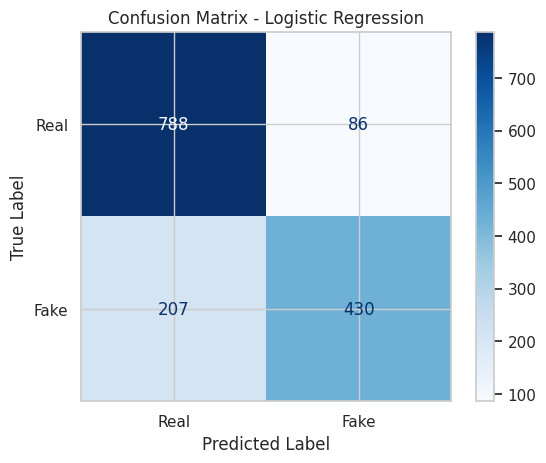

In [67]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Real", "Fake"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
